In [1]:
%matplotlib inline
import re
import string
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing import image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, Bidirectional
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout, LSTM
from tensorflow.keras.layers import Conv1D, Embedding, GlobalAveragePooling1D , MaxPooling2D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv('memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.drop(columns = ['text_ocr', 'humour', 'sarcasm', 'offensive', 'motivational'])
df.head()

,image_name,text_corrected,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [3]:
cleaned = df.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

image_name           False
text_corrected       False
overall_sentiment    False
dtype: bool

In [4]:
width = 60
height = 60
X = []
for i in tqdm(range(cleaned.shape[0])):
    if i in [119, 4799, 6781, 6784, 6786]:
        pass
    else:
        path = 'memotion_dataset_7k/images/'+cleaned['image_name'][i]
        img = image.load_img(path,target_size=(width,height,3))
        img = image.img_to_array(img)
        img = img/255.0
        X.append(img)
        
X = np.array(X)

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 6674/6987 [04:10<00:10, 31.12it/s]D:\Users\hp\anaconda3\envs\Rohit\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6987/6987 [04:21<00:00, 26.73it/s]


In [5]:
X.shape

(6982, 60, 60, 3)

In [6]:
rows_to_drop = ['image_120.jpg',
              'image_4800.jpg',
              'image_6782.jpg',
              'image_6785.jpg',
              'image_6787.jpg',
              'image_6988.jpg',
              'image_6989.jpg',
              'image_6990.png',
              'image_6991.jpg',
              'image_6992.jpg']

In [7]:
for images in rows_to_drop:
    cleaned.drop(cleaned[cleaned['image_name'] == images].index, inplace=True)

In [8]:
import nlpaug
import nlpaug.augmenter.word as naw
from imgaug import augmenters as iaa
def Augmentation(text, images, labels):
    aug = naw.SynonymAug(aug_src='wordnet',aug_max=3)
    augmented_sentences = []
    augmented_sentences_labels = []
    augmented_images = []
    for i in range(0, len(text)):
        if np.argmax(labels.iloc[i]) == 0:
            t = 'negative'
            temps = aug.augment(text.iloc[i],n=6)
            for j in range(6):
                trans = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=(10,30))])
                augmented_images.append(trans(image = images[i]))
                image = augmented_images[j]
        elif np.argmax(labels.iloc[i]) == 1:
            t = 'neutral'
            temps = aug.augment(text.iloc[i],n=2)
            for j in range(2):
                trans = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=(10,30))])
                augmented_images.append(trans(image = images[i]))
                image = augmented_images[j]
        else:
            augmented_sentences.append(text.iloc[i])
            augmented_sentences_labels.append('positive')
            augmented_images.append(images[i])
            continue
        for sent in temps:
            augmented_sentences.append(sent)
            augmented_sentences_labels.append(t)
        
    return augmented_sentences, augmented_images, augmented_sentences_labels

In [9]:
target = cleaned['overall_sentiment']
target = pd.get_dummies(target)
text, images, sent = Augmentation(cleaned.text_corrected, X, target)
cleaned = pd.DataFrame()
cleaned['text'] = text
cleaned['sentiment'] = sent

D:\Users\hp\anaconda3\envs\Rohit\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

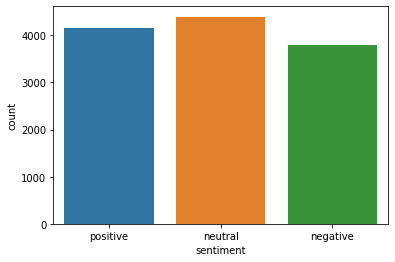

In [10]:
sns.countplot(cleaned.sentiment)

In [11]:
target = cleaned['sentiment']
target = pd.get_dummies(target)
cleaned.shape, np.array(images).shape,target.shape

((12335, 2), (12335, 60, 60, 3), (12335, 3))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, target, test_size = 0.2, stratify=target)

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomContrast([.5,2]),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [55]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(cleaned.text, target, test_size = 0.2, stratify=target)

In [15]:
base_model_1 = tf.keras.applications.ResNet50(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')
# base_model_2 = tf.keras.applications.VGG16(input_shape=X[0].shape,
#                                                include_top=False,
#                                                weights='imagenet')

In [16]:
base_model_1.trainable = False
#base_model_2.trainable = False

In [17]:
def image_model():
    image_input = tf.keras.Input(shape=(60, 60, 3), name = 'image_input')
    image_layers = data_augmentation(image_input)
    image_layers = preprocess_input(image_layers)
    layer_bm_1 = base_model_1(image_input, training=False)
    layer_bm_1 = Conv2D(2048, kernel_size=2,padding='valid')(layer_bm_1)
    #layer_bm_1 = Dense(512)(layer_bm_1)
#     layer_bm_2 = base_model_2(image_input, training=False)
#     layer_bm_2 = Dense(512)(layer_bm_2)
#     layers = tf.keras.layers.concatenate([layer_bm_1, layer_bm_2])
    image_layers = GlobalAveragePooling2D()(layer_bm_1)
    image_layers = Dropout(0.2, name = 'dropout_layer')(image_layers)
    return image_input, image_layers

In [18]:
image_input, image_layers = image_model()

In [19]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

In [20]:
def remove_stopwords(data):
    data['text'] = data['text'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords)]))
    return data

def remove_tags(string):
    result = re.sub('<.*?>','',string)
    return result
 
data_without_stopwords = []
data_without_stopwords = remove_stopwords(cleaned)
data_without_stopwords['text']= data_without_stopwords['text'].apply(lambda cw : remove_tags(cw))
data_without_stopwords['text'] = data_without_stopwords['text'].str.replace('[{}]'.format(string.punctuation), ' ')

C:\Users\hp\AppData\Local\Temp\ipykernel_13880\1822268650.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  data_without_stopwords['text'] = data_without_stopwords['text'].str.replace('[{}]'.format(string.punctuation), ' ')


In [21]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_text_train)

words_to_index = tokenizer.word_index

In [22]:
def read_fasttext_vector(fasttext_vec):
    with open(fasttext_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

In [23]:
word_to_vec_map = read_fasttext_vector('crawl-300d-2M.vec')

maxLen = 50

In [24]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index-1, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [51]:
embedding_dim=16

def text_model():
    text_input = tf.keras.Input(shape=(maxLen,), dtype=tf.int32, name='text')
    text_layers = embedding_layer(text_input)
    print(text_layers)
    
    text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='relu', return_sequences=True))(text_layers)
    text_layers = tf.keras.layers.BatchNormalization()(text_layers)
    text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='relu', return_sequences=True))(text_layers)
    text_layers = tf.keras.layers.BatchNormalization()(text_layers)
#     text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, activation='relu', return_sequences=True))(text_layers)
#     text_layers = tf.keras.layers.BatchNormalization()(text_layers)

    text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
    
    text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
    
    text_layers = tf.keras.layers.GlobalMaxPooling1D()(text_layers)

    text_layers = tf.keras.layers.Dense(2048, activation="relu")(text_layers)
    text_layers = tf.keras.layers.Dropout(0.5)(text_layers)
    return text_input, text_layers

text_input, text_layers = text_model()

KerasTensor(type_spec=TensorSpec(shape=(None, 50, 300), dtype=tf.float32, name=None), name='embedding/embedding_lookup/Identity_1:0', description="created by layer 'embedding'")


In [52]:
def model(layer_1, layer_2, image_input, text_input):
    maximum = tf.keras.layers.Maximum()([layer_1, layer_2])
    semi_final_layer = tf.keras.layers.Dense(256, activation='softmax')(maximum)

    prediction_layer = tf.keras.layers.Dense(3, activation='sigmoid', name = 'memes')

    output = prediction_layer(semi_final_layer)

    model = tf.keras.Model(inputs = [image_input, text_input] , 
                           outputs = output)
    return model

In [53]:
model = model(image_layers, text_layers, image_input, text_input)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 300)      4280700     text[0][0]                       
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 50, 1024)     3330048     embedding[1][0]                  
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 50, 1024)     4096        bidirectional_2[0][0]            
____________________________________________________________________________________________

In [56]:
X_text_train = tokenizer.texts_to_sequences(X_text_train)
X_text_train = pad_sequences(X_text_train, maxlen=maxLen, padding='post')

In [57]:
X_train = tf.stack(X_train)
X_text_train = tf.stack(X_text_train)
y_train = tf.stack(y_train)

In [58]:
X_text_train.shape

TensorShape([9868, 50])

In [59]:
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
img = []
txt = []
for (i,j) in zip(X_train,X_text_train):
    img.append(i)
    txt.append(j)
#X = np.expand_dims(img, axis=0).astype(np.float32)
#X = preprocess_input(X)

In [62]:
conv_output = model.get_layer("maximum").output
pred_ouptut = model.get_layer("memes").output

In [63]:
from tensorflow.keras.models import Model
mod = Model(model.input, outputs=[conv_output, pred_ouptut])

In [64]:
im =tf.stack(img)
txt = tf.stack(txt)
# txt = tokenizer.texts_to_sequences(txt.numpy())
# txt = np.expand_dims(txt, axis=0)
# im = np.expand_dims(img,axis=0)

In [65]:
im.shape

TensorShape([9868, 60, 60, 3])

In [66]:
conv = []
pred = []
for (i,j) in zip(im,txt):
    i = np.expand_dims(i, axis=0)
    j = np.expand_dims(j,axis=0)
    c, p = mod.predict(x = {"image_input": i, "text": j})
    conv.append(c)
    pred.append(p)
# decode_predictions(pred)

In [67]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd 

In [68]:
np.array(conv).shape

(9868, 1, 2048)

In [69]:
conv = reshape(conv, (9868, 2048))

In [70]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(conv) 

D:\Users\hp\anaconda3\envs\Rohit\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Users\hp\anaconda3\envs\Rohit\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9868 samples in 0.016s...
[t-SNE] Computed neighbors for 9868 samples in 3.903s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9868
[t-SNE] Computed conditional probabilities for sample 2000 / 9868
[t-SNE] Computed conditional probabilities for sample 3000 / 9868
[t-SNE] Computed conditional probabilities for sample 4000 / 9868
[t-SNE] Computed conditional probabilities for sample 5000 / 9868
[t-SNE] Computed conditional probabilities for sample 6000 / 9868
[t-SNE] Computed conditional probabilities for sample 7000 / 9868
[t-SNE] Computed conditional probabilities for sample 8000 / 9868
[t-SNE] Computed conditional probabilities for sample 9000 / 9868
[t-SNE] Computed conditional probabilities for sample 9868 / 9868
[t-SNE] Mean sigma: 1.003380
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.653809
[t-SNE] KL divergence after 1000 iterations: 2.673516


[Text(0.5, 1.0, 'T-SNE projection')]

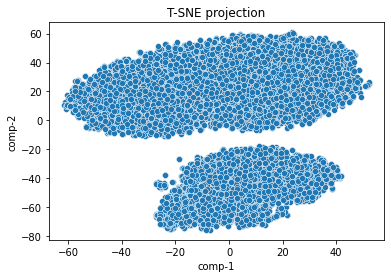

In [71]:
df = pd.DataFrame()
df["y"] = pred
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2",
                palette=sns.color_palette("hls", 3),
                data=df).set(title="T-SNE projection") 

In [72]:
import os
# Define the checkpoint directory to store the checkpoints
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [73]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
    if epoch < 3:
        return 1e-1
    elif epoch >= 3 and epoch < 5:
        return 1e-2
    else:
        return 1e-5

In [74]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [75]:
y_train.shape

TensorShape([9868, 3])

In [76]:
np.array(X_train).shape,X_text_train.shape, y_train.shape

((9868, 60, 60, 3), TensorShape([9868, 50]), TensorShape([9868, 3]))

In [77]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics='accuracy')

history = model.fit(x = {"image_input": X_train, "text": X_text_train},
                    y = y_train,
                    batch_size=64,
                    epochs=50
                   )

Epoch 1/50
155/155 [==============================] - 89s 481ms/step - loss: 0.9637 - accuracy: 0.6782
Epoch 2/50
155/155 [==============================] - 74s 478ms/step - loss: 0.8622 - accuracy: 0.6930
Epoch 3/50
155/155 [==============================] - 74s 478ms/step - loss: 0.7856 - accuracy: 0.6930
Epoch 4/50
155/155 [==============================] - 75s 481ms/step - loss: 0.7265 - accuracy: 0.6930
Epoch 5/50
155/155 [==============================] - 75s 483ms/step - loss: 0.6807 - accuracy: 0.6930
Epoch 6/50
155/155 [==============================] - 76s 491ms/step - loss: 0.6449 - accuracy: 0.6929
Epoch 7/50
155/155 [==============================] - 76s 491ms/step - loss: 0.6163 - accuracy: 0.6930
Epoch 8/50
155/155 [==============================] - 76s 489ms/step - loss: 0.5935 - accuracy: 0.6930
Epoch 9/50
155/155 [==============================] - 75s 482ms/step - loss: 0.5751 - accuracy: 0.6930
Epoch 10/50
155/155 [==============================] - 76s 488ms/step - l

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


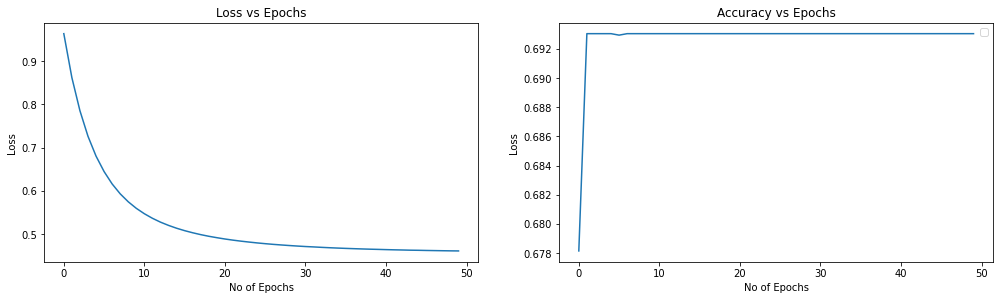

In [78]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
fig.tight_layout(pad=5.0)

axes[0].plot(pd.DataFrame(history.history).loss)
axes[0].set_xlabel('No of Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss vs Epochs')

axes[1].plot(pd.DataFrame(history.history).accuracy)
axes[1].set_xlabel('No of Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Accuracy vs Epochs')
axes[1].legend()
plt.show()

In [79]:
X_text_test = tokenizer.texts_to_sequences(X_text_test)
X_text_test = pad_sequences(X_text_test, maxlen=maxLen, padding='post')

In [80]:
X_test = tf.stack(X_test)
X_text_test = tf.stack(X_text_test)
y_test = tf.stack(y_test)

In [81]:
eval_ = model.evaluate(x = {"image_input": X_test, "text": X_text_test},
                    y = y_test,
                    batch_size=32,
                    verbose=1
                   )

78/78 [==============================] - 10s 87ms/step - loss: nan - accuracy: 0.3069


In [82]:
from sklearn.metrics import f1_score, classification_report
prediction = model.predict(x = {"image_input": X_test, "text": X_text_test})
prediction = np.array(prediction)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(prediction, axis = 1)))

              precision    recall  f1-score   support

           0       0.31      1.00      0.47       757
           1       0.00      0.00      0.00       879
           2       0.00      0.00      0.00       831

    accuracy                           0.31      2467
   macro avg       0.10      0.33      0.16      2467
weighted avg       0.09      0.31      0.14      2467



D:\Users\hp\anaconda3\envs\Rohit\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\hp\anaconda3\envs\Rohit\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Users\hp\anaconda3\envs\Rohit\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
